In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D,GlobalAveragePooling2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

from helper import *

In [ ]:
# import wandb
# from wandb.keras import WandbCallback

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [4]:
import os
from pathlib import Path
import zipfile
import requests
import numpy as np

from sklearn.metrics import roc_curve


def splits(dataset, TRAIN_RATIO, VAL_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2


train_dataset, val_dataset = splits(ds_train, TRAIN_RATIO, VAL_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

(28, 28, 1)


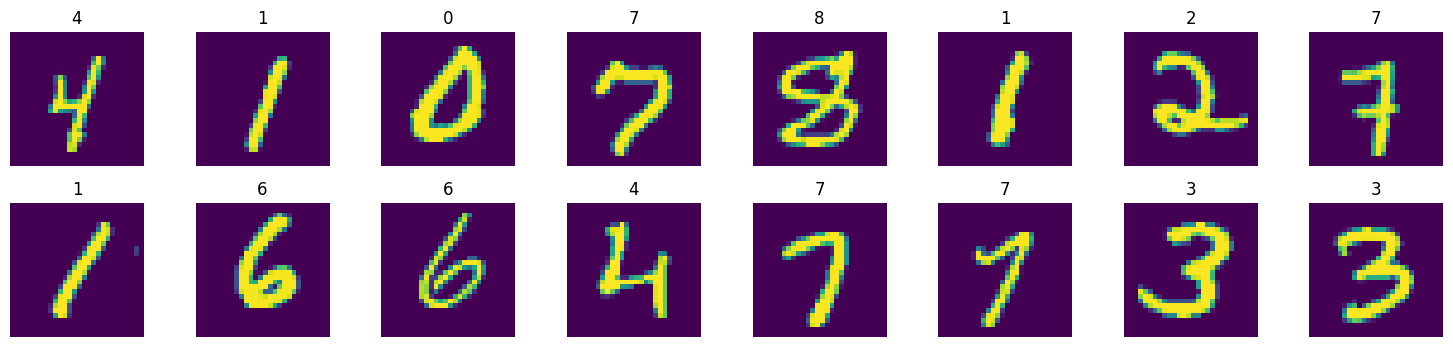

In [6]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label.numpy()))
  plt.axis('off')
print(image.shape)
plt.tight_layout()
plt.show()

In [7]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 32,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}
IM_SIZE =32

In [30]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255., label


def augment_0(image, label):
  image, label = resize_rescale(image, label)

  return image, label

def augment_1(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label


def augment_2(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label


def augment_3(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.flip_left_right(image)
  return image, label


def augment_4(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  return image, label


def augment_5(image, label):
  image, label = resize_rescale(image, label)

  return image, label

In [31]:
def visualize(original_image, Augmented_image):
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  plt.imshow(Augmented_image)
  plt.tight_layout()
  plt.show()

In [32]:
original_image, label = next(iter(train_dataset))

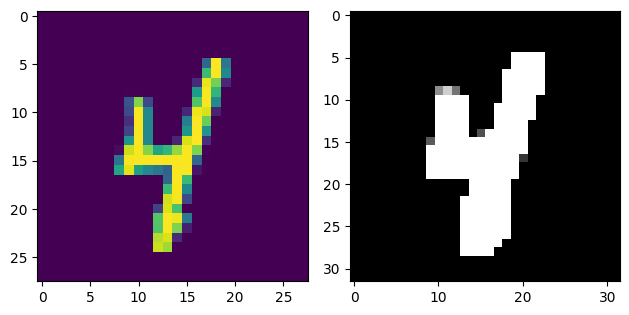

In [33]:
Augmented_image = tf.image.rot90(original_image, k=1, name=None)
Augmented_image = tf.image.flip_left_right(original_image)
Augmented_image = tf.image.adjust_brightness(original_image, delta=0.8)
Augmented_image = tf.image.adjust_contrast(original_image, contrast_factor=19)
Augmented_image = tf.image.random_flip_up_down(original_image)
Augmented_image = tf.image.rot90(original_image, k=2)

# Convert grayscale images to RGB
rgb_images = tf.image.grayscale_to_rgb(original_image)
Augmented_image = tf.image.random_saturation(rgb_images, lower=2, upper=12)
Augmented_image = tf.image.adjust_saturation(
    rgb_images, saturation_factor=0.9, name=None)
Augmented_image = tf.image.random_brightness(
    rgb_images, max_delta=0.1, seed=None)
Augmented_image = tf.image.adjust_gamma(original_image, gamma=0.1, gain=0.1)


Augmented_image = tf.image.central_crop(original_image, central_fraction=0.5)
Augmented_image = tf.image.resize(rgb_images, (IM_SIZE, IM_SIZE))

visualize(original_image, Augmented_image)

In [34]:
train_dataset_0 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_0)
    )
val_dataset_0 = (
    val_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_0)
    )
train_dataset_1 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_1)
    )
val_dataset_1 = (
    val_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_1)
    )
train_dataset_2 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_2)
    )
val_dataset_2 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_2)
)
train_dataset_3 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_3)
    )
val_dataset_3 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_3)
)
train_dataset_4 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_4)
    )
val_dataset_4 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_4)
)
train_dataset_5 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_5)
    )
val_dataset_5 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_5)
)

In [35]:
full_train_dataset = train_dataset_0.concatenate(train_dataset_1).concatenate(train_dataset_2).concatenate(
    train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)
full_val_dataset = val_dataset_0.concatenate(val_dataset_1).concatenate(val_dataset_2).concatenate(
    val_dataset_3).concatenate(val_dataset_4).concatenate(val_dataset_5)

In [36]:
list(full_train_dataset.take(1).as_numpy_iterator())[0][0].shape

(32, 32, 1)

In [37]:
full_train_data = (
    full_train_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)
full_val_data = (
    full_val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

In [38]:
test_ = ds_test.map(resize_rescale)
# test_data = test_.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [39]:
im, lab = next(iter(full_train_data.take(1)))

In [40]:
for image, label in full_train_data.take(1):
    print(image)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [41]:
test_data = test_.batch(1)

In [42]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)

        self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2+4, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)

    def call(self,x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)

        return x


class ModelExtractor(Model):
    def __init__(self):
        super(ModelExtractor, self).__init__()

        self.fetaure_extractor = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training):
        x = self.fetaure_extractor(x)
        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batch_1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

feature_sub_classed = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

model_sub_classed = ModelExtractor()

In [43]:
func_input = Input(shape=(32, 32, 1), name="Input Image")

func_output = model_sub_classed(tf.image.grayscale_to_rgb(func_input))

lenet_model_sub_classed = Model(func_input, func_output, name="Lenet_Model_sub_classed")

lenet_model_sub_classed.summary()

Model: "Lenet_Model_sub_classed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 tf.image.grayscale_to_rgb   (None, 32, 32, 3)         0         
 (TFOpLambda)                                                    
                                                                 
 model_extractor (ModelExtr  (None, 10)                62910     
 actor)                                                          
                                                                 
Total params: 62910 (245.74 KB)
Trainable params: 62458 (243.98 KB)
Non-trainable params: 452 (1.77 KB)
_________________________________________________________________


In [44]:
from datetime import datetime
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self,epoch,logs={}):

        if (logs.get('val_sparse_categorical_accuracy')>=0.992):

            print("99.5% Accuracy is reached .......Hence Stopping")

            self.model.stop_training=True


# Giving call back for accuracy

callbacks = CustomCallback()


# Giving call back for EarlyStopping

early_stopping = EarlyStopping(

    monitor='val_loss',

    min_delta=0.0001,

    patience=15,

    verbose=1,

    mode='auto',

    baseline=None,

    restore_best_weights=True

)


# Logging the losses and metrics data

filename = 'log.csv'

csv_logger = tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)


# Changing Learning Rate with a Scheduler function

def schedule_func(epoch, lr):

    if epoch < 3:

        return lr

    else:

        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_func)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(

    monitor='val_sparse_categorical_accuracy',

                                                    factor=0.1,

                                                    patience=2,

                                                    verbose=1,

                                                    mode='auto',

                                                    min_delta=0.0001,

                                                    min_lr=0.0000001

                                                )


# Saving the best model and its weights to given path

checkpoint_filepath = 'weights/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(

                                                                    filepath=checkpoint_filepath,

                                                                    verbose = 1,

                                                                    save_weights_only=True,

                                                                    save_best_only=True,

                                                                    monitor='val_loss',

                                                                    mode='auto'

                                                                    )
# Including TensorBoard
CURRENT_TIME = datetime.now().strftime('%d%m%y - %b%M%S')
METRIC_DIR = './t_logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

LOG_DIR = './t_logs/' + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR, histogram_freq=1, profile_batch='100,132')


In [45]:
lenet_model_sub_classed.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics=['sparse_categorical_accuracy'])

lenet_history = lenet_model_sub_classed.fit(full_train_data,
                                            validation_data=full_val_data,
                                            epochs=20,
                                            verbose=2,
                                            callbacks = [callbacks,
                                                        early_stopping,
                                                        csv_logger,
                                                        lr_scheduler,
                                                        model_checkpoint_callback,
                                                         tensorboard_callback])

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.60301, saving model to weights/tmp/checkpoint
2250/2250 - 67s - loss: 0.4284 - sparse_categorical_accuracy: 0.8772 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.8085 - lr: 1.0000e-04 - 67s/epoch - 30ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.60301 to 0.44569, saving model to weights/tmp/checkpoint
2250/2250 - 38s - loss: 0.1695 - sparse_categorical_accuracy: 0.9508 - val_loss: 0.4457 - val_sparse_categorical_accuracy: 0.8532 - lr: 1.0000e-04 - 38s/epoch - 17ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.44569 to 0.36489, saving model to weights/tmp/checkpoint
2250/2250 - 34s - loss: 0.1167 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 0.8791 - lr: 1.0000e-04 - 34s/epoch - 15ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.36489 to 0.31442, saving model to weights/tmp/checkpoint
2250/2250 - 33s - loss: 0.0897 - sparse_categorical_accuracy: 0.9733 - val_loss

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# tensorboard --logdir './t_logs' --port=6007

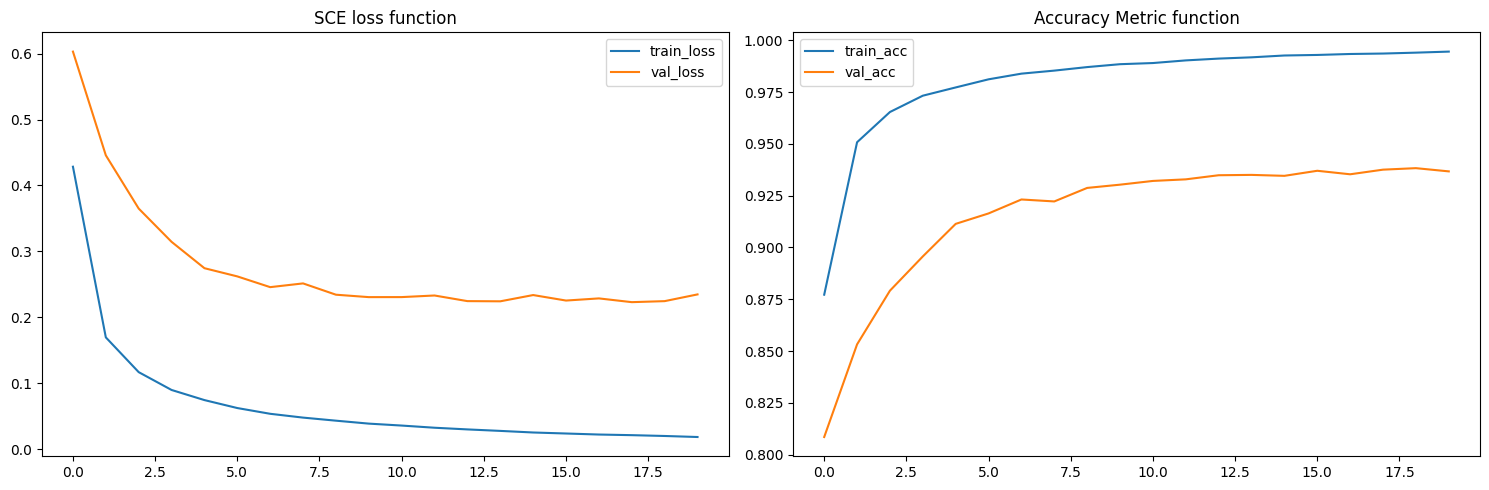

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(lenet_history.history['loss'], label="train_loss")
ax[0].plot(lenet_history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(lenet_history.history['sparse_categorical_accuracy'],
           label="train_acc")
ax[1].plot(lenet_history.history['val_sparse_categorical_accuracy'],
           label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

In [47]:
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 45s 4ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9881


[0.03784351050853729, 0.988099992275238]

1/1 [==============================] - 0s 18ms/step


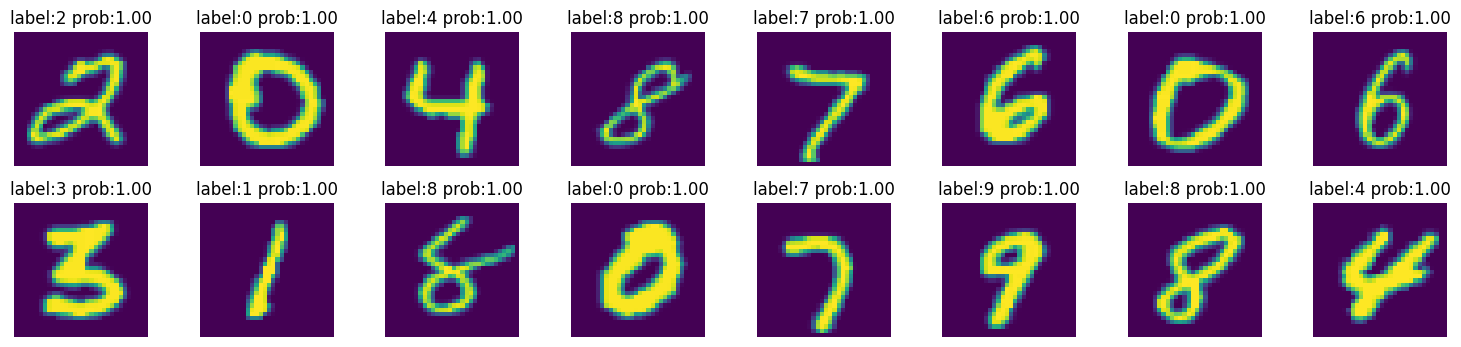

In [48]:
plt.figure(figsize=(15, 7))

for i, (image, label) in enumerate(test_data.take(16)):

  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(tf.squeeze(image, axis=0))

  pred_prob_lst = lenet_model_sub_classed.predict(image)

  pred_label = np.argmax(pred_prob_lst)

  pred_prob = np.max(pred_prob_lst)

  plt.title(f"label:{pred_label} prob:{pred_prob:.2f}")
  plt.axis('off')
plt.tight_layout()

plt.show()

In [49]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
)

71686520/71686520 [==============================] - 0s 0us/step


In [50]:
backbone.trainable = False

In [61]:
pretrained_model = tf.keras.Sequential([
    Input(shape=(32, 32, 1)),
    tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(1200, activation="relu"),
    BatchNormalization(),
    Dense(800, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="softmax"),

])
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 32, 32, 3)         0         
                                                                 
 efficientnetb4 (Functional  (None, 1, 1, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1200)              2151600   
                                                                 
 batch_normalization_9 (Bat  (None, 1200)              4800      
 chNormalization)                                                
                                                      

In [62]:
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics=['sparse_categorical_accuracy'])

pretrained_model_history = pretrained_model.fit(full_train_data,
                                            validation_data=full_val_data,
                                            epochs=10,
                                            verbose=2,
                                            callbacks=[callbacks,
                                                       early_stopping,
                                                       csv_logger,
                                                       lr_scheduler,
                                                       model_checkpoint_callback
                                                       ])

Epoch 1/10

Epoch 1: val_loss did not improve from 0.22292
2250/2250 - 108s - loss: 1.6368 - sparse_categorical_accuracy: 0.4186 - val_loss: 3.8698 - val_sparse_categorical_accuracy: 0.2768 - lr: 1.0000e-04 - 108s/epoch - 48ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.22292
2250/2250 - 90s - loss: 1.3812 - sparse_categorical_accuracy: 0.5110 - val_loss: 1.9034 - val_sparse_categorical_accuracy: 0.3725 - lr: 1.0000e-04 - 90s/epoch - 40ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.22292
2250/2250 - 88s - loss: 1.2963 - sparse_categorical_accuracy: 0.5438 - val_loss: 5.9692 - val_sparse_categorical_accuracy: 0.2412 - lr: 1.0000e-04 - 88s/epoch - 39ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: val_loss did not improve from 0.22292
2250/2250 - 89s - loss: 1.2319 - sparse_categorical_accuracy: 0.5693 - val_loss: 9.7206 - val_sparse_categorical_accuracy: 0.1614 - lr: 1.0000e-04 - 89s/epoch - 40ms/step
E

In [63]:
inputs = Input(shape=(32, 32, 1), name="Input Image")

y_1 = lenet_model_sub_classed(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1 + 0.5*y_2
ensemble_model = Model(inputs=inputs, outputs=output)

In [64]:
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['sparse_categorical_accuracy'])

In [65]:
ensemble_model.evaluate(test_data)

10000/10000 [==============================] - 239s 23ms/step - loss: 0.3246 - sparse_categorical_accuracy: 0.9868


[0.32458218932151794, 0.9868000149726868]

In [ ]:
lenet_model_sub_classed.save_weights('weights/lenet_weights')
lenet_model_sub_classed.load_weights('weights/lenet_weights')
lenet_model_sub_classed.evaluate(test_data)

In [ ]:
lenet_model_sub_classed.load_weights(checkpoint_filepath)
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 29s 3ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9888


[0.05957506597042084, 0.9887999892234802]